<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1RfN4XDprnJCyq7sFjCbj1o68qDv4dIjg'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)
!unzip dataset.zip

Setting up the datasets

In [3]:
import pandas as pd
from glob import glob

# Replace 'path_to_images' with your actual folder path
au_files = sorted(glob('/content/Output/Au_paded/*.png'))
tp_files = sorted(glob('/content/Output/Tp_paded/*.png'))
gt_files = sorted(glob('/content/Output/Gt_paded/*.png'))


# Assuming filenames are aligned, you can create a dataframe like this:
df = pd.DataFrame({
    'photoshopped': tp_files,
    'ground_truth': gt_files
})


In [4]:
print(len(au_files))
print(len(tp_files))
print(len(gt_files))
df.head()


6475
3367
3367


,photoshopped,ground_truth
0,/content/Output/Tp_paded/Tp_D_CND_M_N_ani00018...,/content/Output/Gt_paded/Tp_D_CND_M_N_ani00018...
1,/content/Output/Tp_paded/Tp_D_CND_M_N_art00076...,/content/Output/Gt_paded/Tp_D_CND_M_N_art00076...
2,/content/Output/Tp_paded/Tp_D_CND_M_N_art00077...,/content/Output/Gt_paded/Tp_D_CND_M_N_art00077...
3,/content/Output/Tp_paded/Tp_D_CND_S_N_ani00073...,/content/Output/Gt_paded/Tp_D_CND_S_N_ani00073...
4,/content/Output/Tp_paded/Tp_D_CND_S_N_ind00078...,/content/Output/Gt_paded/Tp_D_CND_S_N_ind00078...


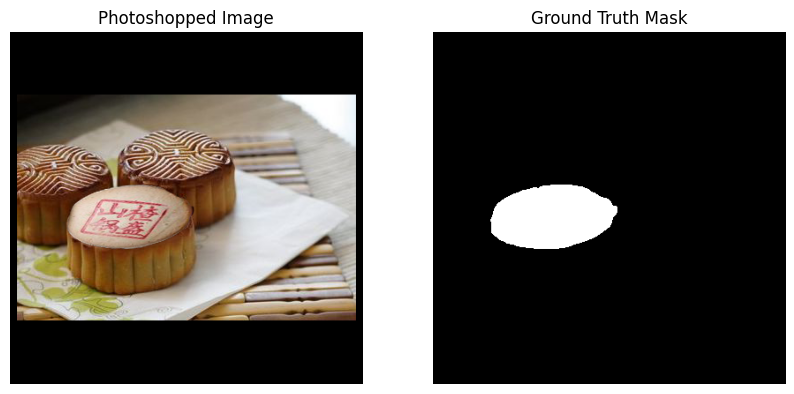

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to display a row of images (photoshopped and ground truth)
def show_images(photoshopped_path, ground_truth_path):
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    titles = ['Photoshopped Image', 'Ground Truth Mask']

    # Load the photoshopped image
    photoshopped_image = Image.open(photoshopped_path)
    axes[0].imshow(photoshopped_image)
    axes[0].set_title(titles[0])
    axes[0].axis('off')  # Hide the axis ticks and labels

    # Load the ground truth mask
    ground_truth_image = Image.open(ground_truth_path)
    axes[1].imshow(ground_truth_image)
    axes[1].set_title(titles[1])
    axes[1].axis('off')  # Hide the axis ticks and labels

    plt.show()

# Display the first set of images
show_images(df['photoshopped'][1], df['ground_truth'][1])


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load images and masks
        photoshopped_path = self.dataframe.iloc[idx]['photoshopped']
        ground_truth_path = self.dataframe.iloc[idx]['ground_truth']

        # Read the images using PIL
        photoshopped_image = Image.open(photoshopped_path)
        ground_truth_mask = Image.open(ground_truth_path).convert('L')  # Convert to grayscale

        # Apply transformations
        if self.image_transform:
            photoshopped_image = self.image_transform(photoshopped_image)
        if self.mask_transform:
            ground_truth_mask = self.mask_transform(ground_truth_mask)

        return photoshopped_image, ground_truth_mask


In [7]:
# Define the transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [8]:
from torch.utils.data import DataLoader

df2 = df.iloc[:100]

# Create the dataset
dataset = CustomDataset(dataframe=df2, image_transform=image_transform, mask_transform=mask_transform)

# Create a dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



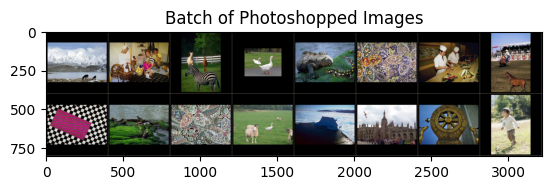

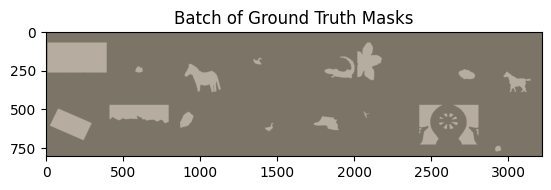

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])  # Unnormalize
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to make sure it's between 0 and 1
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update plots

# Get a batch of training data
dataiter = iter(dataloader)
images, masks = next(dataiter)

# Create a grid from batch
out = torchvision.utils.make_grid(images)
imshow(out, title="Batch of Photoshopped Images")

# Similarly, display the masks
mask_out = torchvision.utils.make_grid(masks)
imshow(mask_out, title="Batch of Ground Truth Masks")


Building the UNet model

In [10]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

                # Encoder
        self.down1 = self.conv_stage(3, 16)   # Reduced from 32 to 16
        self.down2 = self.conv_stage(16, 32)  # Reduced from 64 to 32
        self.down3 = self.conv_stage(32, 64)  # Reduced from 128 to 64
        self.down4 = self.conv_stage(64, 128) # Reduced from 256 to 128
        # Decoder
        self.up1 = self.up_conv_stage(128, 64)
        self.up2 = self.up_conv_stage(64, 32)
        self.up3 = self.up_conv_stage(32, 16)
        self.up4 = self.up_conv_stage(16, 8)   # New: further reduced the output of last up-conv stage

        # Final output layer
        self.final = nn.Conv2d(8, 1, kernel_size=1)

    def conv_stage(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def up_conv_stage(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Decoder
        x = self.up1(x4)
        x = self.up2(x + x3)
        x = self.up3(x + x2)
        x = self.up4(x + x1)

        return self.final(x)

# Create the model
model = UNet()
#print(model)


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [ ]:
def train(model, dataloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Call the training function
train(model, dataloader, criterion, optimizer, num_epochs=25)
